# Réseaux génératifs adversiels (GAN)

Les réseaux de neurones sont souvent utilisés pour des tâches de classification ou de régression. On prend ici l'association de deux ANNs, un qui génère à partir de pixels aléatoires des images - le générateur, et un autre qui classifie les images générées comme 'vraies' ou 'fausses', en se basant sur la base de données sur laquelle il s'est entrainé.
Ici est utilisée la  bibliothèque PyTorch, qui permet de construire des réseaux de façon simple.

Les Gans sont un type d'apprentissage non-supervisé, qui découvre implicitement les motifs ou les irrégularités qui rendent uniques ces images, des point communs entre elles.

On peut notamment citer le fameux site -- (https://thispersondoesnotexist.com) 

<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

Architecture en images

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>


La base de données utilisée ici est celle collectée pour le projet http://pizzagan.csail.mit.edu/ 
Elle contient 10 000 images de 3 dimensions (R,G,B) 
Le code ci-dessous reprend de larges parties du code https://www.kaggle.com/splcher/starter-anime-face-dataset, qui reprend la structure du réseau optimisée trouvée et mentionnée dans la publication sur les DCGan https://paperswithcode.com/method/dcgan

Notamment, elle présente les meilleures fonction d'activation (entre les couches de chaque réseau de neurone et celle de fin), et montre qu'il vaut mieux ne pas faire des couches super connectées, afin qu'elles soient plus indépendantes et que chaque partie puisse analyser une caractéristique de l'image.

Plus d'informations quant au côté technique sont données au fur et à mesure

## Initalisation

On récupère le fichier zip depuis google drive

In [ ]:
# connecter google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z x /content/drive/MyDrive/WIP/landscape.zip -o/content/images/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/WIP/                                     1 file, 1078687940 bytes (1029 MiB)

Extracting archive: /content/drive/MyDrive/WIP/landscape.zip
 81% 4096 Open              --
Path = /content/drive/MyDrive/WIP/landscape.zip
Type = zip
Physical Size = 1078687940

  0%      1% 97 - content/drive/MyDrive/impressi . playing-in-the-fields-1879.jpg                                                                           3% 165 - content/drive/MyDrive/impressi . s-boatyard-moret-sur-loin

## Donnés 
chemin relatif des données

In [ ]:
DATA_DIR = '/content/images/content/pic'

dossier imageres qui contient les **10 000 images**

In [ ]:
import os

print(os.listdir(DATA_DIR))

['impressionist_landscapes_resized_1024']


In [ ]:
print(os.listdir(DATA_DIR+'/impressionist_landscapes_resized_1024/')[:10])

['claude-monet_valley-of-falaise.jpg', 't-c-steele_haying-scene-1884.jpg', 'gustave-courbet_beach-in-normandy.jpg', 'john-singer-sargent_pomegranates-majorca-1908.jpg', 'janos-mattis-teutsch_plough-land-1916.jpg', 'hans-am-ende_weyerberg-under-the-clouds-1899.jpg', 'gustave-loiseau_by-the-eure-river.jpg', 'armand-guillaumin_landscape-of-puy-de-d-me.jpg', 'alfred-william-finch_orchard-at-la-louviere-1890.jpg', 'gustave-loiseau_tournedos-sur-seine-1901.jpg']


On importe le dataset avec la classe `ImageFolder` de `torchvision`. On redimensionne les images en normalisant les valeurs des pixels avec une moyenne et une déviation standart. Ainsi, les pixels ont une valeur entre -1 et 1, ce qui est plus pratique pour entraîner le discriminateur.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
ims = 64
batch_size = 128 #quantité d'images dans un lot
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

On définit des fonctions auxiliaires pour dénormaliser les vecteurs de nombres et les afficher sous forme d'images

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Voici un exemple de pizzas d'entrée

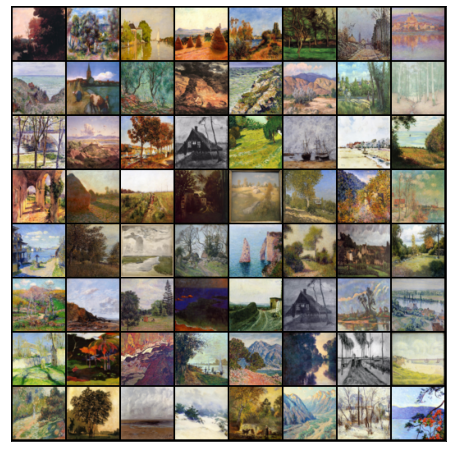

In [ ]:
show_batch(train_dl)

## Utiliser un GPU

PyTorch facilite l'utilisation d'un GPU, indispensable pour l'entrainement du réseau. On utilise les fonctions(`get_default_device` & `to_device`) et une classe d'aide `DeviceDataLoader` pour transférer les données et les modèles au GPU.

In [ ]:
def get_default_device():
    """choisir GPU si disponible"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Déplacer tensors à l'appareil (GPU ou CPU) choisi"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Dataloader pour déplacer base de données"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Garder en mémoire le batch donné"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """taille du batch (élements par lot)"""
        return len(self.dl)

L'appareil est soit un CPU (`torch.device('cpu')`) ou un GPU (`torch.device('cuda')`).

In [ ]:
device = get_default_device()
device

device(type='cuda')

On déplace nos données d'entraînement avec `DeviceDataLoader` qui les envoie automatiquement par batch (lot) au GPU.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminateur


Il prend une image en entrée et essaye de la classifier en tant que vraie ou génerée. On utilse ici une structure classique, un CNN (Convolutional Neural Network), qui par un filtre qui ~moyenne les pixels 
réduit la taille des données jusqu'à ce qu'elles aient une unique dimension


![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

on importe PyTorch

In [ ]:
import torch.nn as nn

Voici le réseau classificateur, on peut voir qu'il faut 5 couches pour une image d'entrée de 128 x128 et 4 couches pour 64 x 64.
Les hypermaramètres et les fonctions d'activation (LeakyRelu puis sigmoide) ont été longuement optimisés par des chercheurs, les voici.

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator128 = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, ims, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64


    nn.Conv2d(ims, ims*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*2),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(ims*2, ims*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*4),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(ims*4, ims*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*8),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 1024 x 8 x 8

    
    nn.Conv2d(ims*8, ims*16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 4 x 4

    nn.Conv2d(ims*16, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Fonction LeakyReLU

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Fait passer le gradient (qui sert à optimiser le réseau) d'une façon plus forte, car il n'est maintenat plus uniquement petit (ReLU normal) mais négatif [Source](https://sthalles.github.io/advanced_gans/)


Modèle binaire de classification, renvoie un nombre entre 0 et 1, qui peut être interpreté comme la probabilité que l'image soit réelle, c'est à dire en concordance avec la base de données.

On envoie le discriminateur sur notre GPU (merci Colab)

In [ ]:
discriminator = to_device(discriminator, device)

## Réseau générateur

L'entrée est typicallement un vecteur ou une matrice de nombres aléatoires (latent tensor). Ici on prend le latent tensor `(128, 1, 1)` et on le transforme en  `3 x 28 x 28`. On utilise les couches `ConvTranspose2d` layer de PyTorch, qui agit comme un "déconvolution" [Plus d'infos](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [ ]:
latent_size = 128

Générateur pour images taille 128x128

In [ ]:
generator12 = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, ims*16, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(ims*16),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(ims*16, ims*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*8),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(ims*8, ims*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*4),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(ims*4, ims*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims*2),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(ims*2, ims, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ims),
    nn.ReLU(True),
    # 64x64x64


    nn.ConvTranspose2d(ims, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Générateur 64x64

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Toujours d'après les meilleurs paramètres pour DCGAN, la fonction d'activation, c'est à dire celle qui normalise la dernière valeur, est la tangente hyperbolique. Les autres fonctions qui normalisent à chaque couche intermédiaire sont des fonctions ReLU.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >



Les sorties de la fonction sont comprises entre `[-1,1]`on applique des transformations similaires dans le discriminateur. Générons des données, puis normalisons les afin de les visualiser ensuite.

torch.Size([128, 3, 64, 64])


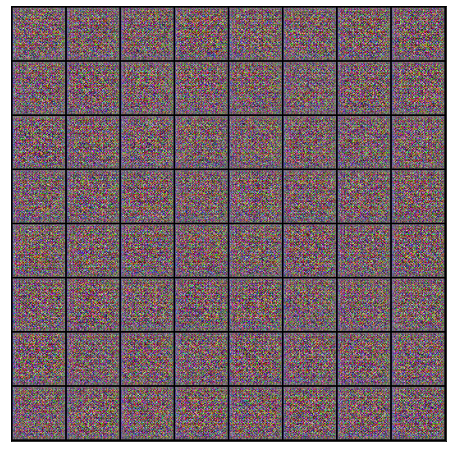

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # latent tensors aléatoires
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


Comme on peut s'y attendre, c'est du bruit aléatoire, puisque on ne l'a pas encore entraîné.

Déplaçons maintenant le générateur sur le GPU

In [ ]:
generator = to_device(generator, device)



## Entraînement du discriminateur


Le discriminateur est un modèle de classification binaire, on utilise la cross-entropie binaire pour quantifier à quel point il est éloigné de la bonne réponse.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [ ]:
def train_discriminator(real_images, opt_d):
    # On réinitialise les gradients
    opt_d.zero_grad()

    # On passe les vraies images 
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # on génère de fausses images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # on passe les fausses images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # on update les loss (pertes, soit à quel point il faut s'améliorer)
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Les étapes nécessaires à l'entrainement du discriminateur.

- On s'attend à ce que le discriminateur renvoie 1 si les images sont vraiment depuis la base de données et 0 si elles on été générées avec le réseau générateur 

- On passe d'abord un lot de vraies images, on calcule les pertes (loss), en mettant la valeur à atteindre à 1.

- Ensuite on passe un lot de fausses images générées, calcule les pertes, en mettant là valeur à atteindre à 0.

- Enfin on additionne les deux pertes en faisant la descente de gradient pour trouver vers quelle direction modifier les poids.


Exemple de gradient simple, en deux dimensions. Ici nous en avons 128

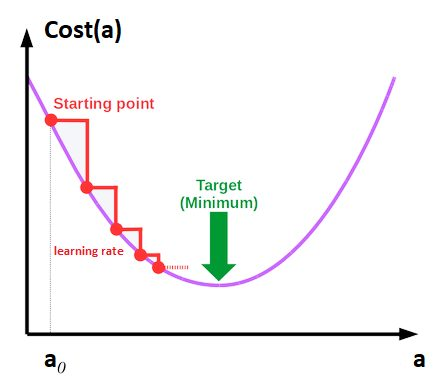

## Entraînement du générateur

Les sorties du générateur sont des images, ce qui n'est pas forcément évidemment à entraîner. C'est pour cette raison qu'on utilise le discriminateur dans une partie de la fonction qui calcule les pertes.
Comment cela fonctionne:

- On génère des images avec le générateur, et on les renvoie au discriminateur.

- On calcule les pertes en mettant l'objectif de la sortie du discriminateur égal à 1, car on souhaite le tromper. 

- On utilise les pertes calculées pour faire la descente de gradient, c'est à dire changer les poids dans les différentes couches du générateur, pour qu'il soit meilleur en génération de pizzas.

Le code :

In [ ]:
def train_generator(opt_g):
    # réinitialiser gradients
    opt_g.zero_grad()
    
    # générer fausses images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # essayer de tromper le générateur en lui demandant de classifier les images générées
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # on met à jour les poids
    loss.backward()
    opt_g.step()
    
    return loss.item()

On crée un dossier où l'on peut enregistrer les images et les poids intermédiaires (façon d'enregistrer les poids expliquée plus bas)

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = '/content/drive/MyDrive/WIP/landscapegen'
os.makedirs(sample_dir, exist_ok=True)

Fonction auxilaire pour nous permettre de créer des images et les enregistrer sur notre disque.

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Enregistrement de ', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Pour visualiser concètement l'évolution de notre modèle avec des images qui deviennent meilleures au fur et à mesure, on va définir un esemble de vecteurs d'entrée qui va évoluer. Enregistrons donc notre premier lot d'images générées.


In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Enregistrement de  generated-images-0000.png


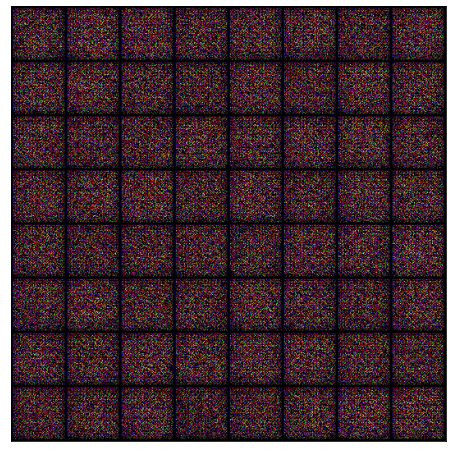

In [ ]:
save_samples(0, fixed_latent)

## Boucle complète d'entraînemet

Boucle qui reprend toutes les fonctions que l'on a définit précedemment, et qui effectue toutes les opérations dans l'ordre - entraîner le discriminateur puis générateur et enregistrer des images.


<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

Voici une fonction pour charger depuis un fichier contenant les derniers ajustements des poids et ainsi ne pas reprendre l'entraînement depuis le début

In [ ]:
def loadone(path, opt_g, opt_d):

  checkpoint = torch.load(path)
  generator.load_state_dict(checkpoint['generator_state_dict'])
  discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
  opt_g.load_state_dict(checkpoint['opt_g_state_dict'])
  opt_d.load_state_dict(checkpoint['opt_d_state_dict'])
  epoch = checkpoint['epoch']

In [ ]:
path = "/content/drive/MyDrive/WIP/landscapegen/37.pt"

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # les pertes et les scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # on définit les optimisateurs
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # on charge le dernier fichier avec les modèles
    loadone(path, opt_g, opt_d)

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # entraîner discriminateur
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # entraîner générateur
            loss_g = train_generator(opt_g)
          
        #on enregistre les hyperparamètres du modèle
        PATH = "/content/drive/MyDrive/WIP/landscapegen/"+ str(epoch)+".pt"
        torch.save({
            'epoch':epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_g_state_dict': opt_g.state_dict(),
            'opt_d_state_dict': opt_d.state_dict()
            }, PATH)
        # on voit les pertes et les scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # on les affiche
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # enregistrement de l'image générée
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

On est prêts à entraîner nos modèles!

Voilà un petit récapitulatif de nos deux réseaux, avec leurs couches et paramètres

In [ ]:
from torchsummary import summary

In [ ]:
summary(generator,  input_size=(128, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
summary(discriminator,  input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [ ]:
lr = 0.0002 #learning rate, de quel pas on avance quand on fait la descente de gradient
epochs = 60 # nombre d'époques pour lesquelles on va entraîner nos modèles

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 3.1065, loss_d: 0.1207, real_score: 0.9149, fake_score: 0.0298
Enregistrement de  generated-images-0001.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 4.6928, loss_d: 0.0467, real_score: 0.9765, fake_score: 0.0221
Enregistrement de  generated-images-0002.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 5.4057, loss_d: 0.0464, real_score: 0.9898, fake_score: 0.0345
Enregistrement de  generated-images-0003.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 0.3927, loss_d: 0.4206, real_score: 0.7176, fake_score: 0.0187
Enregistrement de  generated-images-0004.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 3.6516, loss_d: 0.7665, real_score: 0.8126, fake_score: 0.3395
Enregistrement de  generated-images-0005.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 2.8142, loss_d: 1.1655, real_score: 0.5494, fake_score: 0.1348
Enregistrement de  generated-images-0006.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 5.1682, loss_d: 0.3332, real_score: 0.9314, fake_score: 0.1829
Enregistrement de  generated-images-0007.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 2.5074, loss_d: 0.3943, real_score: 0.7641, fake_score: 0.0941
Enregistrement de  generated-images-0008.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 2.6941, loss_d: 0.3248, real_score: 0.7814, fake_score: 0.0533
Enregistrement de  generated-images-0009.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 3.7102, loss_d: 0.1920, real_score: 0.8906, fake_score: 0.0612
Enregistrement de  generated-images-0010.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 1.2238, loss_d: 0.6089, real_score: 0.6289, fake_score: 0.0357
Enregistrement de  generated-images-0011.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 4.4691, loss_d: 0.1012, real_score: 0.9918, fake_score: 0.0825
Enregistrement de  generated-images-0012.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 2.8828, loss_d: 0.2101, real_score: 0.8475, fake_score: 0.0339
Enregistrement de  generated-images-0013.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 2.5939, loss_d: 0.2653, real_score: 0.8070, fake_score: 0.0355
Enregistrement de  generated-images-0014.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 2.9364, loss_d: 0.2351, real_score: 0.8406, fake_score: 0.0380
Enregistrement de  generated-images-0015.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 3.3480, loss_d: 0.2517, real_score: 0.8209, fake_score: 0.0373
Enregistrement de  generated-images-0016.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 3.9699, loss_d: 0.0791, real_score: 0.9604, fake_score: 0.0363
Enregistrement de  generated-images-0017.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 3.7870, loss_d: 0.1235, real_score: 0.9076, fake_score: 0.0244
Enregistrement de  generated-images-0018.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.2339, loss_d: 0.1250, real_score: 0.9303, fake_score: 0.0481
Enregistrement de  generated-images-0019.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 4.5629, loss_d: 0.0339, real_score: 0.9926, fake_score: 0.0257
Enregistrement de  generated-images-0020.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 2.6574, loss_d: 0.2250, real_score: 0.8447, fake_score: 0.0451
Enregistrement de  generated-images-0021.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.2723, loss_d: 0.0575, real_score: 0.9934, fake_score: 0.0471
Enregistrement de  generated-images-0022.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 2.8647, loss_d: 0.1788, real_score: 0.8704, fake_score: 0.0345
Enregistrement de  generated-images-0023.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.1093, loss_d: 0.0881, real_score: 0.9397, fake_score: 0.0239
Enregistrement de  generated-images-0024.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 4.5436, loss_d: 0.0297, real_score: 0.9955, fake_score: 0.0245
Enregistrement de  generated-images-0025.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 3.1262, loss_d: 0.1372, real_score: 0.8957, fake_score: 0.0238
Enregistrement de  generated-images-0026.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 2.3375, loss_d: 0.1867, real_score: 0.8535, fake_score: 0.0160
Enregistrement de  generated-images-0027.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 3.5306, loss_d: 0.1105, real_score: 0.9150, fake_score: 0.0199
Enregistrement de  generated-images-0028.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 3.6785, loss_d: 0.1222, real_score: 0.9175, fake_score: 0.0324
Enregistrement de  generated-images-0029.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.6738, loss_d: 0.0448, real_score: 0.9848, fake_score: 0.0280
Enregistrement de  generated-images-0030.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 2.5514, loss_d: 0.1566, real_score: 0.8877, fake_score: 0.0263
Enregistrement de  generated-images-0031.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 2.4008, loss_d: 0.1805, real_score: 0.8525, fake_score: 0.0135
Enregistrement de  generated-images-0032.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 2.7609, loss_d: 0.1472, real_score: 0.9080, fake_score: 0.0459
Enregistrement de  generated-images-0033.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 1.6213, loss_d: 0.2617, real_score: 0.8080, fake_score: 0.0236
Enregistrement de  generated-images-0034.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 7.6166, loss_d: 0.6203, real_score: 0.6562, fake_score: 0.0464
Enregistrement de  generated-images-0035.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 3.8912, loss_d: 0.7245, real_score: 0.6739, fake_score: 0.1077
Enregistrement de  generated-images-0036.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 5.0314, loss_d: 0.4959, real_score: 0.8830, fake_score: 0.2338
Enregistrement de  generated-images-0037.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 4.7920, loss_d: 0.1226, real_score: 0.9549, fake_score: 0.0676
Enregistrement de  generated-images-0038.png


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Voyons l'évolution des images

In [ ]:
from IPython.display import Image

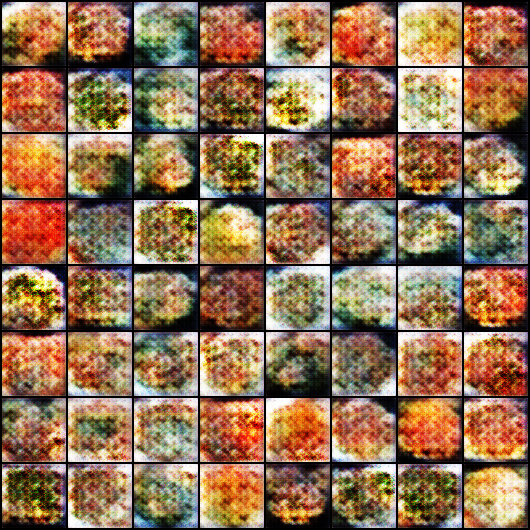

In [ ]:
Image(sample_dir+'/8.png')

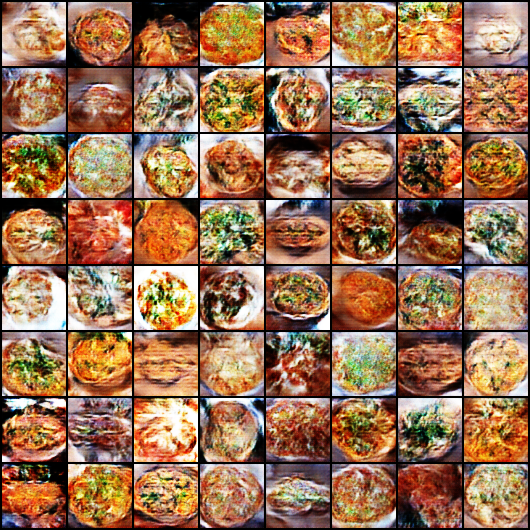

In [ ]:
Image(sample_dir+'/generated-images-0004.png')

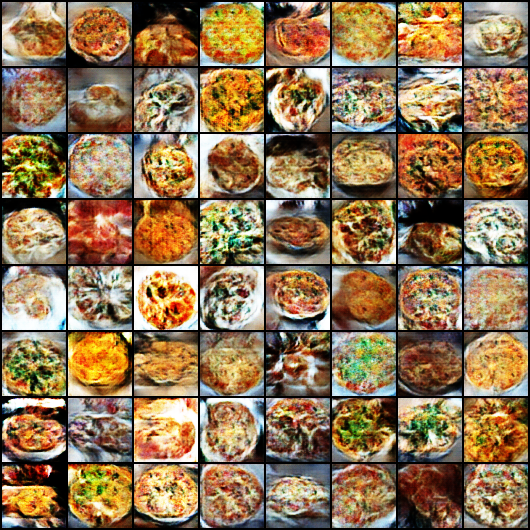

In [ ]:
Image(sample_dir+'/generated-images-0010.png')

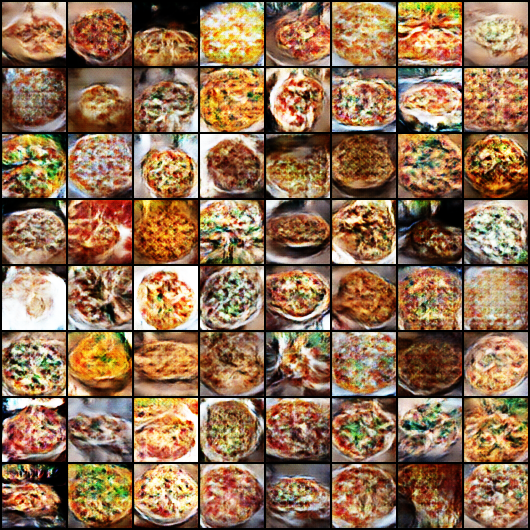

In [ ]:
Image(sample_dir+'/generated-images-0020.png')

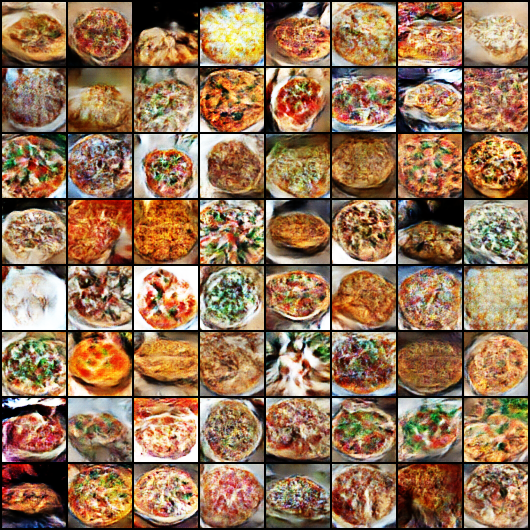

In [ ]:
Image(sample_dir+'/generated-images-0030.png')

On peut aussi voir comment les pertes et les scores évoluent avec le temps.
Pour ces réseaux GAN, on devrait s'attendre à ce que les pertes du générateur diminuent au fil des répétitions, tandis que le discriminateur reste assez stable aprèes les premières époques. 

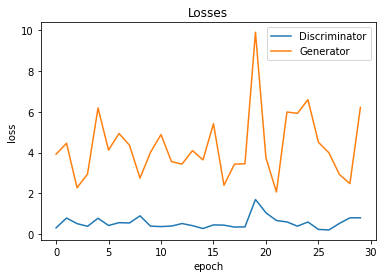

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

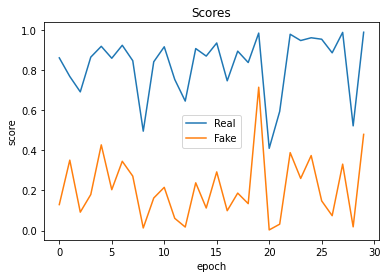

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files=[]
for f in os.listdir(sample_dir):
  if 'generated' in f:
    print(f)
    files.append(os.path.join(sample_dir, f))

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]

out.release()

Générons des images

Remarquons qu'on peut en générer une infinité, ou presque.

In [ ]:
def generimg(path, nom):
  checkpoint = torch.load(path, map_location=torch.device('cpu')) # on charge le fichier avec le modèle entraîné
  generator.load_state_dict(checkpoint['generator_state_dict'])
  xb = torch.randn(batch_size, latent_size, 1, 1) # latent tensors aléatoires
  fake_images = generator(xb) # on fait passer ces données aléatoires dans le réseau
  print(fake_images.shape)
  show_images(fake_images) # on affiche la sortie
  fake_fname = 'generated-images-{}.png'.format(nom)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8) 
  print('Enregistrement de ', fake_fname)

In [ ]:
generimg(path, 'test3')

RuntimeError: ignored